In [1]:
import os
os.environ['DVC_ROOT'] = '..'
import sys
if '..' not in sys.path:
    sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.figure import Figure
from matplotlib.axis import Axis
from matplotlib.collections import PathCollection
import numpy as np
import json
import spacy
from typing import Type, Any

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import trustworthiness
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

from mock import MagicMock
from unittest.mock import patch

from notebooks.results import groups_to_latex_table, to_latex_table

from stages.models.Model import Model
from stages.vectorizers.Vectorizer import Vectorizer
from stages.datacleaners.DataCleaner import DataCleaner
from stages.dataloaders.DataLoader import DataLoader

from stages.datacleaners.DummyDatacleaner import DummyDatacleaner

from stages.dataloaders.PrusVsSienkiewicz import PrusVsSienkiewicz
from stages.dataloaders.Classics5Authors35Books import Classics5Authors35Books

from stages.vectorizers.BigramMorphTagVectorizer370 import BigramMorphTagVectorizer370

from stages.models.LogisticRegression import LogisticRegression

from stages.models.AffinityPropagation import AffinityPropagation
from stages.models.DBSCAN import DBSCAN
from stages.models.KMeans import KMeans

from tqdm import tqdm


#https://chat.openai.com/share/c8f1af4b-daef-4065-8ac6-4ff0575c1bcc

2024-06-03 19:04:36.985 | DEBUG    | utils.spacy_gpu:resolve_spacy_batch_size:47 - Spacy: resolved batch size to 500 (default) since NO env var present.


In [2]:
TAGS = {'abbr_yes': 0, 'adptype_post': 1, 'adptype_prep': 2, 'animacy_hum': 3, 'animacy_inan': 4, 'animacy_nhum': 5,
        'aspect_imp': 6, 'aspect_imp,perf': 7, 'aspect_perf': 8, 'case_acc': 9, 'case_dat': 10, 'case_gen': 11,
        'case_ins': 12, 'case_loc': 13, 'case_nom': 14, 'case_voc': 15, 'clitic_yes': 16, 'conjtype_comp': 17,
        'conjtype_oper': 18, 'conjtype_pred': 19, 'degree_cmp': 20, 'degree_pos': 21, 'degree_sup': 22,
        'emphatic_yes': 23, 'foreign_yes': 24, 'gender_fem': 25, 'gender_masc': 26, 'gender_neut': 27, 'hyph_yes': 28,
        'mood_imp': 29, 'mood_ind': 30, 'number[psor]_plur': 31, 'number[psor]_sing': 32, 'number_plur': 33,
        'number_plur,sing': 34, 'number_ptan': 35, 'number_sing': 36, 'numform_digit': 37, 'numform_roman': 38,
        'numform_word': 39, 'numtype_card': 40, 'numtype_ord': 41, 'numtype_sets': 42, 'parttype_int': 43,
        'parttype_mod': 44, 'person_0': 45, 'person_1': 46, 'person_2': 47, 'person_3': 48, 'polarity_neg': 49,
        'polarity_pos': 50, 'polite_depr': 51, 'poss_yes': 52, 'prepcase_npr': 53, 'prepcase_pre': 54,
        'prontype_dem': 55, 'prontype_ind': 56, 'prontype_int': 57, 'prontype_neg': 58, 'prontype_prs': 59,
        'prontype_rel': 60, 'prontype_tot': 61, 'pun_no': 62, 'pun_yes': 63, 'punctside_fin': 64, 'punctside_ini': 65,
        'puncttype_brck': 66, 'puncttype_colo': 67, 'puncttype_comm': 68, 'puncttype_dash': 69, 'puncttype_elip': 70,
        'puncttype_excl': 71, 'puncttype_peri': 72, 'puncttype_qest': 73, 'puncttype_quot': 74, 'puncttype_semi': 75,
        'puncttype_slsh': 76, 'reflex_yes': 77, 'tense_fut': 78, 'tense_past': 79, 'tense_pres': 80, 'variant_long': 81,
        'variant_short': 82, 'verbform_conv': 83, 'verbform_fin': 84, 'verbform_inf': 85, 'verbform_part': 86,
        'verbform_vnoun': 87, 'verbtype_mod': 88, 'verbtype_quasi': 89, 'voice_act': 90, 'voice_pass': 91}

In [3]:
bigrams: list[tuple[str, str]] = sorted(list(set([
            (tag1, tag2)
            for tag1 in TAGS.keys()
            for tag2 in TAGS.keys()
        ])))
len(bigrams)

8464

In [4]:
def calculate_visualisation_metrics(embeddings, embeddings_2d, labels):
    no_labels = len(set(labels))
    # Davies-Bouldin score
    db_score = davies_bouldin_score(embeddings_2d, labels=labels) if no_labels != 1 else float('nan')

    # Calinski-Harabasz score
    ch_score = calinski_harabasz_score(embeddings_2d, labels=labels) if no_labels != 1 else float('nan')

    # Neighbor preservation
    trustworthiness_score = trustworthiness(embeddings, embeddings_2d, n_neighbors=5)

    # Global structure preservation
    dist_high = euclidean_distances(embeddings)
    dist_low = euclidean_distances(embeddings_2d)
    # stress = np.sqrt(((dist_high - dist_low) ** 2).sum()) / np.sqrt((dist_high ** 2).sum())
    stress = cosine_distances(dist_high, dist_low).mean()

    return db_score, ch_score, trustworthiness_score, stress

In [5]:
def save_json_results(self, dataset: str, datacleaner: str, vectorizer: str, params_name: str,
                      params: dict[str, str | int | float], metrics: dict[str, float]) -> None:
        dirs_in_path = ["results", dataset, datacleaner, vectorizer, self.__class__.__name__]
        path = '.'
        print(path)

        for p in dirs_in_path:
            path = os.path.join(path, p)
            if not os.path.exists(path):
                os.makedirs(path)

        filename = f"{params_name}.json"
        results = {'params': params, 'metrics': metrics, 'dataset': dataset, 'datacleaner': datacleaner,
                   'vectorizer': vectorizer, 'params_name': params_name}
        with open(os.path.join(path, filename), 'w') as file:
            json.dump(results, file)


def log_clusters_plot(x: np.ndarray, labels: np.ndarray, reduction_method='PCA', data_out=None):
    reducer = get_reducer(reduction_method)
    x_reduced = reducer.fit_transform(x)
    db_score, ch_score, trustworthiness_score, stress = calculate_visualisation_metrics(x, x_reduced, labels=labels)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax: Axis = ax
    labels_count = len(np.unique(labels))

    for label in np.unique(labels):
        cluster = x_reduced[labels == label]
        ax.scatter(cluster[:, 0], cluster[:, 1], label=str(label), alpha=0.4)
    ax.set_title(f'{reduction_method}')
    if labels_count > 10:
        ax.legend(fontsize=8)
    else:
        ax.legend()

    if data_out is not None:
         data = {
            'x': x,
            'x_reduced': x_reduced,
            'labels': labels,
            'reduction': reduction_method,
            'db': db_score,
            'ch': ch_score,
            'trustworthiness': trustworthiness_score,
            'stress': stress,
            'fig': fig
         }
         data_out.append(data)
    


def get_reducer(name: str):
    reducers = {
        'PCA': PCA(n_components=2),
        'TSNE': TSNE(n_components=2),
        'UMAP': UMAP(n_components=2)
    }
    return reducers[name]


def log_confusion_matrix_plot(conf_matrix: np.ndarray, data_out=None):
    """Plot confusion matrix."""
    if data_out is not None:
         data_out.append(conf_matrix)
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)
    ax.set_title('Macierz pomyłek')
    ax.set_xlabel('przewidziane wartości')
    ax.set_ylabel('poprawne wartości')


X_DATA, Y_DATA = None, None
def log_figure(fig: Figure, path):
     ...

In [6]:
def metrics_to_df(results: list[dict[str, Any]]) -> pd.DataFrame:
    data = []
    for res in results:
        data.append({
            'davies-bouldin': res['db'],
            'calinski-harabasz': res['ch'],
            'trustworthiness': res['trustworthiness'],
            'stress': res['stress'],
            'model_name': res['model_name'],
            'reduction': res['reduction']
        })
    return pd.DataFrame(data)


In [7]:
@patch('utils.metrics.classification._log_confusion_matrix_plot')
@patch('utils.metrics.clusterization._log_clusters_plot')
@patch('utils.mlflow.experiments.mlflow_context')
@patch('utils.mlflow.experiments._resolve_experiment_id')
@patch('utils.mlflow.experiments._zip_mlflow_output')
@patch('utils.mlflow.experiments.mlflow')
@patch('utils.metrics.clusterization.mlflow')
@patch('utils.metrics.classification.mlflow')
def run(
    ModelType: Type[Model],
    dataset: DataLoader,
    datacleaner: DataCleaner,
    vectorizer: Vectorizer,
    params_name: str,
    params: dict[str, str | int | float],
    clas_mlflow_patch: MagicMock, 
    clus_mlflow_patch: MagicMock, 
    exp_mlflow_patch: MagicMock,
    zip_mlflow_output_patch: MagicMock,
    resolve_experiment_id_patch: MagicMock, 
    mlflow_context_patch: MagicMock, 
    lcp_patch: MagicMock, 
    lcm_patch: MagicMock
) -> list[np.ndarray]:
    clus_mlflow_patch.log_figure = log_figure
    clas_mlflow_patch.log_figure = log_figure
    results = []
    lcp_patch.side_effect = lambda x, labels, reduction_method: log_clusters_plot(x, labels, reduction_method, results)
    lcm_patch.side_effect = lambda conf_matrix: log_confusion_matrix_plot(conf_matrix, results)
    ModelType.save_json_results = save_json_results
    ModelType.save_mlflow_results = MagicMock()
    model = ModelType()
    model.evaluate(
        dataset if isinstance(dataset, str) else dataset.__class__.__name__, 
        datacleaner if isinstance(datacleaner, str) else datacleaner.__class__.__name__, 
        vectorizer if isinstance(vectorizer, str) else vectorizer.__class__.__name__, 
        params_name, 
        params
    )
    for method, d in zip(['PCA', 'TSNE', 'UMAP'], results):
        fig: Figure = d['fig']
        path = os.path.join(
            "results", 
            dataset if isinstance(dataset, str) else dataset.__class__.__name__, 
            datacleaner if isinstance(datacleaner, str) else datacleaner.__class__.__name__, 
            vectorizer if isinstance(vectorizer, str) else vectorizer.__class__.__name__, 
            model.__class__.__name__,
            f'plot_{method}.svg'
        )
        temp_path = f"temp_graph/{method}.png"
        fig.savefig(path)
        fig.savefig(temp_path)
    return results

In [8]:
DummyDatacleaner = 'DummyDatacleaner'
ProperNamesMasker = 'ProperNamesMasker'

2024-06-03 20:20:08.984 | INFO     | stages.models.KMeans:evaluate:19 - Fitting KMeans...
2024-06-03 20:20:11.823 | INFO     | utils.metrics.clusterization:compute_clustering_metrics:27 - Preparing plots...
2024-06-03 20:21:32.661 | INFO     | utils.metrics.clusterization:compute_clustering_metrics:31 - Clustering metrics: silhouette: 0.6452093720436096 davies_bouldin: 0.5215145520426248 calinski_harabasz: 30339.528139342096
2024-06-03 20:23:04.507 | INFO     | utils.metrics.clusterization:compute_b_cubed_metrics:47 - B-Cubed metrics: bcubed_precission: 0.832102115223319 bcubed_recall: 0.8409813032300802 bcubed_f1: 0.83651814794494


.


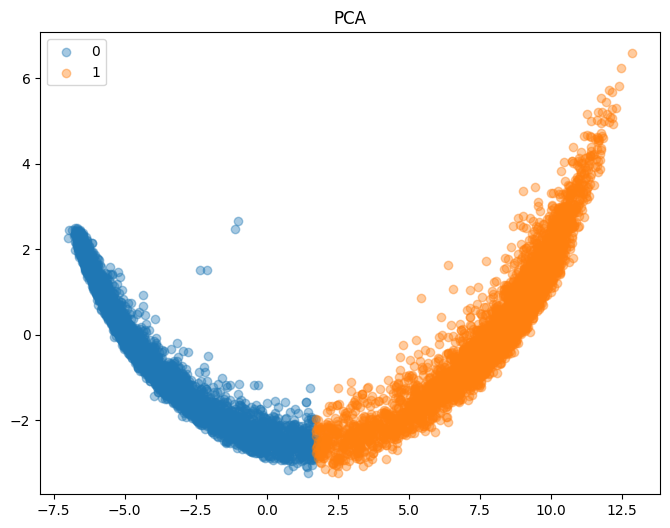

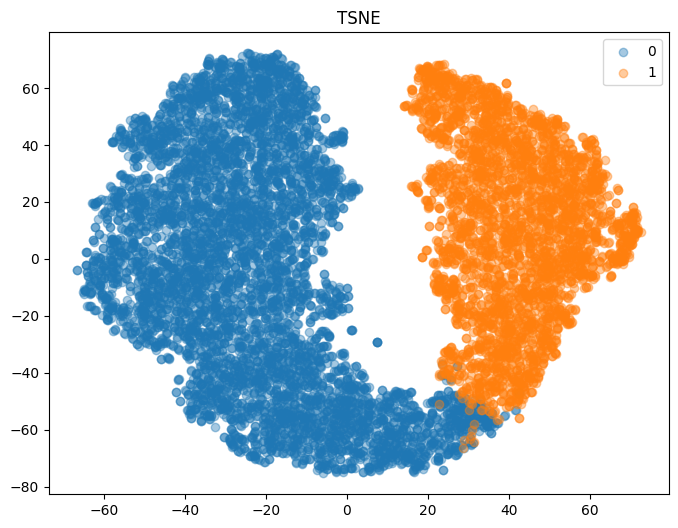

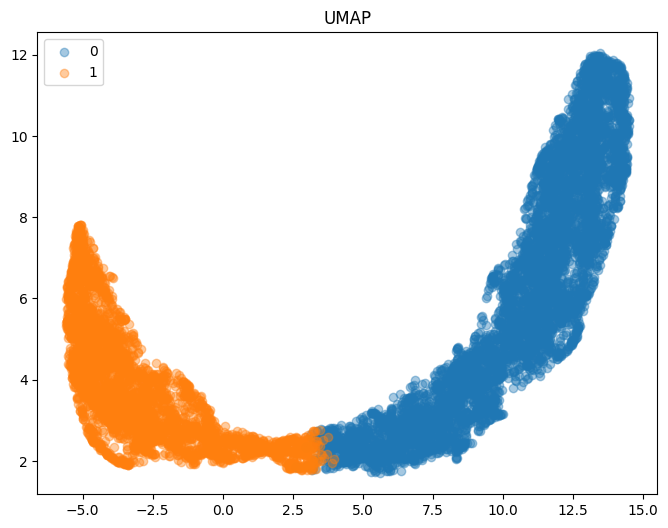

In [20]:
dataset = 'EroticVsOthers'
data_cleaner = DummyDatacleaner
vectorizer = 'HerbertFT'
model = KMeans

res = run(
    model,
    dataset,
    data_cleaner,
    vectorizer,
    model.__name__,
    {
        # 'eps': 1.5,
        # 'n_jobs': -1
    }
)
for d in res:
    d['model_name'] = model.__name__

In [21]:
df = metrics_to_df(res)[['reduction', 'davies-bouldin', 'calinski-harabasz', 'trustworthiness', 'stress']]
df

,reduction,davies-bouldin,calinski-harabasz,trustworthiness,stress
0,PCA,0.369237,48571.064284,0.944435,0.245114
1,TSNE,1.089079,5688.179127,0.994208,0.205118
2,UMAP,0.442596,31590.347838,0.972374,0.234118


In [22]:
print(to_latex_table(
    df,
    column_names=['redukcja', 'IDB', 'ICH', 'ZS', 'ZSG'],
    bold_labels=['stress', 'trustworthiness'],
    caption=f'Wizualizacja przestrzeni osadzeń modelu {vectorizer} z różnymi metodami redukcji wymiarowości dla'
))

\begin{table}[!htb]
	\centering
	\caption{Wizualizacja przestrzeni osadzeń modelu HerbertFT z różnymi metodami redukcji wymiarowości dla}
	\resizebox{
	\ifdim\width>\columnwidth
		\columnwidth
	\else
		\width
	\fi
	}{!}{
	\begin{tabular}{|c|c|c|c|c|}
		\hline
		\textbf{redukcja} & \textbf{IDB} & \textbf{ICH} & \textbf{ZS} & \textbf{ZSG} \\
		\hline
		PCA & 0,369 & 48571,064 & 0,944 & \textbf{0,245} \\
		TSNE & 1,089 & 5688,179 & \textbf{0,994} & 0,205 \\
		UMAP & 0,443 & 31590,348 & 0,972 & 0,234 \\
		\hline
	\end{tabular}
	}
	\label{tab:}
\end{table}
